<a href="https://colab.research.google.com/github/lauraciurca/A-ML-Approach-for-Detecting-Brute-Force-Attacks/blob/main/MODEL_IMPLEMENTATION_AND_EVALUATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [1]:
from google.colab import drive
import glob
import pandas as pd 
from ast import literal_eval
import numpy as np
from datetime import datetime
from itertools import groupby
from datetime import datetime
import statistics
from scipy.stats import skew
from scipy.stats import norm, kurtosis
from statsmodels.tsa.stattools import adfuller
import itertools
import matplotlib.pyplot as plt 
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV
import random
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from scipy.stats import kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
attacks= pd.read_csv('/content/drive/MyDrive/A_project/attacks.csv')
normal= pd.read_csv('/content/drive/MyDrive/A_project/normal.csv')

In [4]:
attacks = attacks.rename(columns={'durata_media_attacco2': 'mean'})
normal = normal.rename(columns={'durata_media_attacco2': 'mean'})

**Functions**

In [14]:
def train_osvm(train_data, kernel, best_nu, best_gamma):

	model = OneClassSVM(nu=best_nu, kernel=kernel, gamma=best_gamma)
	model.fit(train_data)
 	
	return model 

In [15]:
def train_if(train_data, max_samples):

    rng= np.random.RandomState(42)
    model = IsolationForest(max_samples=max_samples,random_state=rng)
    model.fit(train_data)
 	
    return model 

In [16]:
def train_predictions(model, train_data): 
	train_predictions = model.predict(train_data)
	return train_predictions

In [17]:
def test_predictions(model, test_data):
	test_predictions = model.predict(test_data)
	return test_predictions

In [18]:
def plot_confusion_matrix(cm, title, classes=['normal', 'attack'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

**One-Class SVM**

In [19]:
data_attacks=attacks.copy()
data_normal=normal.copy()

In [20]:
data_attacks["label"]= 1
data_normal["label"]= -1

In [21]:
data_attacks[["durata_attacco","fails","mean","standard_deviation","kurtosis","skewness","label"]].head()

,durata_attacco,fails,mean,standard_deviation,kurtosis,skewness,label
0,791296,239,5.975000,0.158114,35.025641,-6.084870,1
1,12026811,3599,5.998333,0.040825,595.001669,-24.433618,1
2,12270854,4061,7.124561,13.554560,259.732973,15.968529,1
3,591243,179,5.966667,0.182574,25.034483,-5.199469,1
4,387166,118,5.900000,0.447214,15.052632,-4.129483,1


In [22]:
relevant_features = ["durata_attacco","fails","mean","skewness","standard_deviation","kurtosis"]  

Visualization of Dataset After PCA

In [ ]:
#frames = [data_attacks, data_normal]
#result = pd.concat(frames)
#result = result.reset_index(drop=True)

In [ ]:
#principal_components = pd.DataFrame(data = components
#             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
#principal_components['y'] = result["label"]

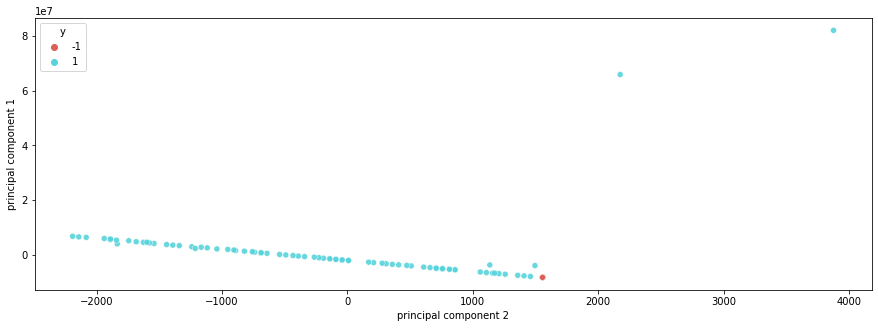

In [ ]:
#plt.figure(figsize=(15,5))
#sns.scatterplot(
#    x="principal component 2", y="principal component 1",
#    hue="y",
#    palette=sns.color_palette("hls", 2),
#    data=principal_components,
#    legend="full",
#    alpha=0.9
#)

Preparing data through train and test split and scaling

In [23]:
attacks1, attacks2 = train_test_split(data_attacks, train_size = 0.7, random_state=12)
test_set= pd.concat([attacks2, data_normal], axis=0)
test_set=test_set.reset_index(drop=True)
x_test=test_set[relevant_features]
attacks1=attacks1.reset_index(drop=True)
x_train= attacks1[relevant_features]

In [24]:
y_test=test_set["label"]
y_train=attacks1["label"]

In [25]:
scaler=StandardScaler()
x_train= pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

In [32]:
#rng = np.random.RandomState(42)

In [27]:
np.random.seed(43)

In [ ]:
#PCA
pca = PCA(n_components=2)             
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.49923373, 0.35424977])

In [29]:
#count label distribution
counter = Counter(y_test)
print(counter)

Counter({1: 25, -1: 10})


In [30]:
outliers = y_test[y_test == -1] 
nu = outliers.shape[0] / y_test.shape[0] 
nu

0.2857142857142857

Cross-validation

In [ ]:
nuu= [0.25,0.28,0.29]

In [ ]:
gg=["auto","scale"]

In [ ]:
parameters = { 'nu' : nuu, 'gamma': gg }

svm = OneClassSVM(kernel="rbf")

score = ['precision_macro' ,'f1_macro']

In [ ]:
svm_model = GridSearchCV(svm, parameters, cv = 5, scoring = score, refit='f1_macro')  
svm_model.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='scale', kernel='rbf', max_iter=-1,
                                   nu=0.5, shrinking=True, tol=0.001,
                                   verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': ['auto', 'scale'], 'nu': [0.25, 0.28, 0.29]},
             pre_dispatch='2*n_jobs', refit='f1_macro',
             return_train_score=False, scoring=['precision_macro', 'f1_macro'],
             verbose=0)

In [ ]:
print("Parameter value with the best score:")
svm_model.best_params_

Parameter value with the best score:


{'gamma': 'scale', 'nu': 0.25}

In [ ]:
#avg_f1_scores = Series(svm_model.cv_results_['mean_test_f1_macro'], name = 'avg_f1_scores')
#nu  = Series([x['nu'] for x in svm_model.cv_results_['params']], name = 'nu')
#gamma  = Series([x['gamma'] for x in svm_model.cv_results_['params']], name = 'gamma')                            
#svm_validation_scores = pd.concat([nu, gamma, avg_f1_scores], axis = 1)
#svm_validation_scores

Training the model with best parameters

In [ ]:
oneclass= train_osvm(x_train,"rbf", 0.25, 'scale')   
test_preds = test_predictions(oneclass, x_test)

In [ ]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

          -1       0.56      1.00      0.71        10
           1       1.00      0.68      0.81        25

    accuracy                           0.77        35
   macro avg       0.78      0.84      0.76        35
weighted avg       0.87      0.77      0.78        35



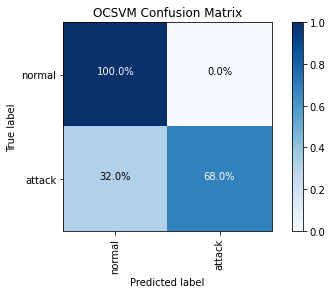

In [ ]:
cm=confusion_matrix(y_test,test_preds)
plot_confusion_matrix(cm, title="OCSVM Confusion Matrix", save=True, saveas="OCSVM.png")

**Isolation Forest**

Cross-validation

In [ ]:
max_samples=[5,8,10,20]

In [ ]:
parameters = { 'max_samples': max_samples }
clf = IsolationForest()
score = ['precision_macro' ,'f1_macro']

In [ ]:
if_model = GridSearchCV(clf, parameters, cv = 5, scoring = score, refit='f1_macro')  
if_model.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=None,
                                       verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_samples': [5, 8, 10, 20]},
             pre_dispatch='2*n_jobs', refit='f1_macro',
             return_train_score=False, scoring=['precision_macro', 'f1_macro'],
             verbose=0)

In [ ]:
print("Parameter value with the best score:")
if_model.best_params_

Parameter value with the best score:


{'max_samples': 5}

Isolation Forest with best values of parameters

In [ ]:
isolationf=train_if(x_train,5)
y_test_pred = test_predictions(isolationf, x_test)

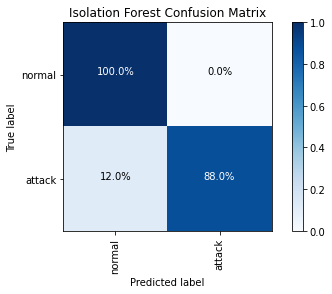

In [ ]:
cm_is=confusion_matrix(y_test,y_test_pred)       
plot_confusion_matrix(cm_is, title="Isolation Forest Confusion Matrix", save=True, saveas="IF_SAs.png")

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.62      0.64      0.63        25

    accuracy                           0.46        35
   macro avg       0.31      0.32      0.31        35
weighted avg       0.44      0.46      0.45        35



3-D Representation of One-Class SVM/Isolation Forest

In [ ]:
#model = OneClassSVM(kernel="rbf", nu=0.25, gamma="scale")
model = IsolationForest(max_samples=5, random_state=rng)
model.fit(x_train)
test_predictions = model.predict(x_test)
X_set, y_set = x_test, y_test

In [ ]:
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
Xpred = np.array([X1.ravel(), X2.ravel()] + [np.repeat(0, X1.ravel().size) for _ in range(0)]).T 
pred = model.predict(Xpred).reshape(X1.shape) 

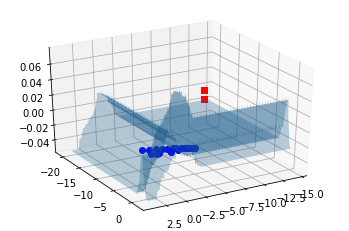

In [ ]:
z = model.decision_function(Xpred).reshape(X1.shape)
tmp = np.linspace(-5,5,30)
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot3D(X_set[y_set == 1,0], X_set[y_set == 1,1], 'ob')
ax.plot3D(X_set[y_set == -1,0], X_set[y_set == -1,1], 'sr')
ax.plot_surface(X1, X2, z, alpha=0.3)
ax.view_init(30, 60)
plt.show()